### LSTM(Long Short Term Memory)
#### RNN에 기반한 딥러닝 아키텍쳐
- LSTM은 긴 시간동안의 정보를 기억하기 위한 모델
- 학습을 너무 많이 시키면 오버피팅이 날 수 있음 적절한 횟수를 학습시켜줘야함

train data 496행, test data 77행으로

비율은 0.87 : 0.13 정도 

LSTM : 오늘을 포함한 50거래일의 OHLCV(=input data)을 바탕으로 내일의 종가 예측

-> OHLCV (open, high, low, close, volume)로 당일 시가, 고가, 저가, 종가, 거래량

모델을 짜서 트레이닝 시킨다
1. input, X : t = 0~49's OHLCV (0-1 Minmax Scale)
2. Model : LSTM, dropout={0.2}, {64} hidden layers in between, activation = {sigmoid}
3. Optimizer : {Adam}, learning rate = {0.0005}, Loss = {mse}
4. Training : batch_size = {32}, epochs = {50}
5. Output, y : t = 50's O -> C
다음날 open price를 살펴본다 -> 종가로

In [48]:
# 필요패키지
import pandas as pd
from sklearn import preprocessing
import numpy as np
# import FinanceDataReader as fdr
import tensorflow as tf

In [49]:
# train으로 사용할 주가데이터 불러오기 2020년1월2일~ 2021년12월30일
train_data = pd.read_csv('data/주가_train_data.csv')
train_data.tail() # 496행 

,Unnamed: 0,Date,Open,High,Low,Close,Adj.Close,Volume,?쇱씪醫낃?李⑥씠
491,492,2021-12-24,113000.0,115000,112500.0,114500,114446.5313,1484508,1500
492,493,2021-12-27,114000.0,114500,113000.0,113000,112947.2344,1116701,-1500
493,494,2021-12-28,113000.0,114000,113000.0,113500,113447.0000,2370856,500
494,495,2021-12-29,115500.0,117500,114000.0,114000,114000.0000,1791503,500
495,496,2021-12-30,114000.0,114500,112500.0,112500,112500.0000,1223078,-1500


In [50]:
# test로 사용할 주가데이터 불러오기 2022년1월4일~ 2022년4월27일
test_data = pd.read_csv('data/주가_test_data.csv')
test_data.tail() # 77행

,Unnamed: 0,Date,Open,High,Low,Close,Adj.Close,Volume,일일종가차이
72,569,2022-04-21,95100.0,95100,93100,93600.0,93600.0,1809576,-1500
73,570,2022-04-22,92200.0,92400,91400,92000.0,92000.0,1553904,-1600
74,571,2022-04-25,90400.0,91600,89600,89700.0,89700.0,1511408,-2300
75,572,2022-04-26,89800.0,91700,89700,90200.0,90200.0,1368258,500
76,573,2022-04-27,87600.0,88900,87600,88400.0,88400.0,1379033,-1800


In [51]:
data1 = pd.concat([train_data,test_data])
data1 = data1.loc[:,['Date','Open','High','Low','Close','Volume']]
data1.set_index('Date', inplace=True)
data1

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,30800.0,30900,30400.0,30500.0,1205235
2020-01-03,30700.0,31000,30200.0,30500.0,1574240
2020-01-06,30100.0,31000,30000.0,30900.0,1968575
2020-01-07,31000.0,32000,30900.0,32000.0,4200930
2020-01-08,31700.0,32400,31300.0,31900.0,4258095
...,...,...,...,...,...
2022-04-21,95100.0,95100,93100.0,93600.0,1809576
2022-04-22,92200.0,92400,91400.0,92000.0,1553904
2022-04-25,90400.0,91600,89600.0,89700.0,1511408


In [52]:
# 전체 데이터 합치기
data = pd.concat([train_data,test_data])
# OHLCV 컬럼만 추출하고, DATE컬럼은 행 인덱스로 변경
data = data.loc[:,['Date','Open','High','Low','Close','Volume']]
data.set_index('Date', inplace=True)
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,30800.0,30900,30400.0,30500.0,1205235
2020-01-03,30700.0,31000,30200.0,30500.0,1574240
2020-01-06,30100.0,31000,30000.0,30900.0,1968575
2020-01-07,31000.0,32000,30900.0,32000.0,4200930
2020-01-08,31700.0,32400,31300.0,31900.0,4258095
...,...,...,...,...,...
2022-04-21,95100.0,95100,93100.0,93600.0,1809576
2022-04-22,92200.0,92400,91400.0,92000.0,1553904
2022-04-25,90400.0,91600,89600.0,89700.0,1511408


In [7]:
data.index

Index(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07', '2020-01-08',
       '2020-01-09', '2020-01-10', '2020-01-13', '2020-01-14', '2020-01-15',
       ...
       '2022-04-14', '2022-04-15', '2022-04-18', '2022-04-19', '2022-04-20',
       '2022-04-21', '2022-04-22', '2022-04-25', '2022-04-26', '2022-04-27'],
      dtype='object', name='Date', length=573)

In [53]:
data=data.values # 값만 갖고온다
data

array([[  30800.,   30900.,   30400.,   30500., 1205235.],
       [  30700.,   31000.,   30200.,   30500., 1574240.],
       [  30100.,   31000.,   30000.,   30900., 1968575.],
       ...,
       [  90400.,   91600.,   89600.,   89700., 1511408.],
       [  89800.,   91700.,   89700.,   90200., 1368258.],
       [  87600.,   88900.,   87600.,   88400., 1379033.]])

In [54]:
def call_dataset(history_points = 50):
    
    print('data 행열개수: ', data.shape)
    
    # 머신러닝 전처리
    # MinMaxScaler 정규화 - 데이터 값을 0~1 범위로 변경
    data_normalizer = preprocessing.MinMaxScaler() # 함수 call
    data_normalized = data_normalizer.fit_transform(data) # 함수 수행
    print('data_normalized: ', data_normalized.shape)
    
    # 50개의 OHLCV를 사용하여 관찰일수(50개) 만큼 누적.(열방향으로)
    ohlcv_histories_normalized = np.array([data_normalized[i:i + history_points].copy() for i in range(len(data_normalized) - history_points)])
    print('ohlcv_histories_normalized: ', ohlcv_histories_normalized.shape)

    # 종가(close) 정규화값 누적
    next_day_close_values_normalized = np.array([data_normalized[:, 3][i + history_points].copy() for i in range(len(data_normalized) - history_points)])
    next_day_close_values_normalized = np.expand_dims(next_day_close_values_normalized, -1) # 1XN 벡터 -> NX1 벡터로

    # 종가(close) 값 누적
    next_day_close_values = np.array([data[:, 3][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_close_values = np.expand_dims(next_day_close_values, -1) # 1XN 벡터 -> NX1 벡터로
    
    # y값(종가 값) 정규화 - 데이터 값을 0~1 범위로 변경
    y_normalizer = preprocessing.MinMaxScaler()
    y_normalizer.fit(next_day_close_values)

    # 인풋 X : 그 이전의 OHLCV (from T = -50 to T = -1)
    # 아웃풋 y : 예측하고자 하는 주가 T = 0

    # 지수 이동 평균(EMA) 계산
    # https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
    def calc_ema(values, time_period): # values : 종가, time_period : ema의 일 수
        sma = np.mean(values[:, 3]) # sma는 기간동안의 종가 합계를 나눈 값
        ema_values = [sma] 
        k = 2 / (1 + time_period) # time_period : ema의 일 수
        for i in range(len(his) - time_period, len(his)): # his 개수 - ema의 일수 ~ his 개수까지 for문
            close = his[i][3] # his의 종가
            ema_values.append(close * k + ema_values[-1] * (1 - k)) # ema = 가격 * k + ema * (1-k)
        return ema_values[-1]

    # 기술지표    
    technical_indicators = []
    for his in ohlcv_histories_normalized: # 관찰일수만큼 쌓은 train데이터
        # his[3]을 사용하기 때문의 종가의 sma를 취한다.
        sma = np.mean(his[:, 3]) # 각 데이터포인트별 Close Price 평균
        macd = calc_ema(his, 12) - calc_ema(his, 26) # calc_ema함수호출 : 12일 EMA - 26일 EMA
        technical_indicators.append(np.array([sma]))

    # 배열로 변환
    technical_indicators = np.array(technical_indicators)

    # MinMaxScaler 정규화 - 데이터 값을 0~1 범위로
    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalized = tech_ind_scaler.fit_transform(technical_indicators)

    assert ohlcv_histories_normalized.shape[0] == next_day_close_values_normalized.shape[0] == technical_indicators_normalized.shape[0]
    
    print('ohlcv_histories_normalized.shape[0]: ', ohlcv_histories_normalized.shape[0])

    return ohlcv_histories_normalized, technical_indicators_normalized, next_day_close_values_normalized, next_day_close_values, y_normalizer

In [55]:
history_points = 50

import keras
# funciontal api() 사용 
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers
np.random.seed(4)
# tensorflow 에서 set_random_seed 가져오기
import tensorflow
print(tensorflow.__version__)
tensorflow.random.set_seed(44)
# random으로 생성한 결과가 항상 같은 value를 갖도록 하는 방법

import numpy as np



# call_dataset 함수 호출
ohlcv_histories, _, next_day_close_values, unscaled_y, y_normaliser = call_dataset(history_points=50)

# train 비율 
train_ratio = 0.853
n = int(ohlcv_histories.shape[0] * train_ratio) # n = 523 * 0.85 // 446.119

# input x : ohlcv 50개씩 누적값
ohlcv_train = ohlcv_histories[:n] #ohlcv_histories[:n].shape (446, 50, 5)
# output y : 다음날 종가
y_train = next_day_close_values[:n] #

# x_test : test로 분리된 ohlcv 50개 누적값
ohlcv_test = ohlcv_histories[n:-1] # ohlcv_histories[n:-1].shape (76, 50, 5)
# y_test : test로 분리된 다음날 종가 
y_test = next_day_close_values[n:-1]

# 실제값 y test
unscaled_y_test = unscaled_y[n:-1]

print('ohlcv_train.shape: ', ohlcv_train.shape)
print('ohlcv_test.shape: ',ohlcv_test.shape)

2.8.0
data 행열개수:  (573, 5)
data_normalized:  (573, 5)
ohlcv_histories_normalized:  (523, 50, 5)
ohlcv_histories_normalized.shape[0]:  523
ohlcv_train.shape:  (446, 50, 5)
ohlcv_test.shape:  (76, 50, 5)


In [48]:
ohlcv_histories

array([[[0.02216066, 0.01044568, 0.03616236, 0.02592852, 0.06378542],
        [0.02146814, 0.01114206, 0.03468635, 0.02592852, 0.08331451],
        [0.01731302, 0.01114206, 0.03321033, 0.0287316 , 0.10418415],
        ...,
        [0.04709141, 0.03830084, 0.05830258, 0.04905396, 0.14560008],
        [0.0401662 , 0.03064067, 0.04575646, 0.03784163, 0.32232349],
        [0.0166205 , 0.02019499, 0.02583026, 0.03503854, 0.42391438]],

       [[0.02146814, 0.01114206, 0.03468635, 0.02592852, 0.08331451],
        [0.01731302, 0.01114206, 0.03321033, 0.0287316 , 0.10418415],
        [0.02354571, 0.01810585, 0.0398524 , 0.03644008, 0.2223285 ],
        ...,
        [0.0401662 , 0.03064067, 0.04575646, 0.03784163, 0.32232349],
        [0.0166205 , 0.02019499, 0.02583026, 0.03503854, 0.42391438],
        [0.033241  , 0.02367688, 0.0295203 , 0.01892081, 0.33143006]],

       [[0.01731302, 0.01114206, 0.03321033, 0.0287316 , 0.10418415],
        [0.02354571, 0.01810585, 0.0398524 , 0.03644008, 0.2

In [11]:
ohlcv_histories[n:-1].shape

(76, 50, 5)

In [56]:
# 모델 구성
# 함수형 api는 각각의 변수에 layer를 받아 모듈별로 구성할 수 있으며, 
# 마지막에는 Model()객체에 input과 output텐서를 지정하여 모델을 생성한다.

# 모델 input 레이어 설정 (50개의 time-step, 5개의 feature)
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input) 
x = Dropout(0.2, name='lstm_dropout_0')(x) # 정규화를 위한 레이어
x = Dense(50, name='dense_0')(x) 
# 활성함수는 네트워크에 비선형성(nonlinearity)을 추가하기 위해 사용됨
# 활성화함수 : sigmoid 함수 입력을 (0,1) 사이의 값으로 normalize
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x) # 출력 1
# 활성화함수 : 선형함수 직선적인 함수(y=x)
output = Activation('linear', name='linear_output')(x)
# 모델 생성
model = Model(inputs=lstm_input, outputs=output)

# 모델 훈련
adam = tf.keras.optimizers.Adam(lr=0.0005) # 학습률 설정
model.compile(optimizer=adam, loss='mse') # 손실함수 : mean_squared_error
model.fit(x=ohlcv_train, y=y_train, batch_size=5, epochs=60, shuffle=True, validation_split=0.1)
# input x : ohlcv 50개씩 누적값 # output y : 다음날 종가 
# batch_size=5개씩 묶어서, epochs=60번 학습, 
# shuffle: 각 epochs마다 샘플을 섞는다. # validation_split:검증용도로 사용할 데이터 비율

# 평가 예측
# test데이터를 사용한 예측
y_test_predicted = model.predict(ohlcv_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
# 실제 데이터를 사용한 예측
y_predicted = model.predict(ohlcv_histories)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
# real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
# scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
# print(scaled_mse)

from datetime import datetime
model.save('basic_model.h5')

Epoch 1/60


C:\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


81/81 [==============================] - 2s 10ms/step - loss: 0.0379 - val_loss: 0.0027
Epoch 2/60
81/81 [==============================] - 1s 6ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 3/60
81/81 [==============================] - 1s 7ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 4/60
81/81 [==============================] - 1s 6ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 5/60
81/81 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 3.3911e-04
Epoch 6/60
81/81 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 5.0601e-04
Epoch 7/60
81/81 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 4.0089e-04
Epoch 8/60
81/81 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 2.9841e-04
Epoch 9/60
81/81 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 3.4084e-04
Epoch 10/60
81/81 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 2.4439e-04
Epoch

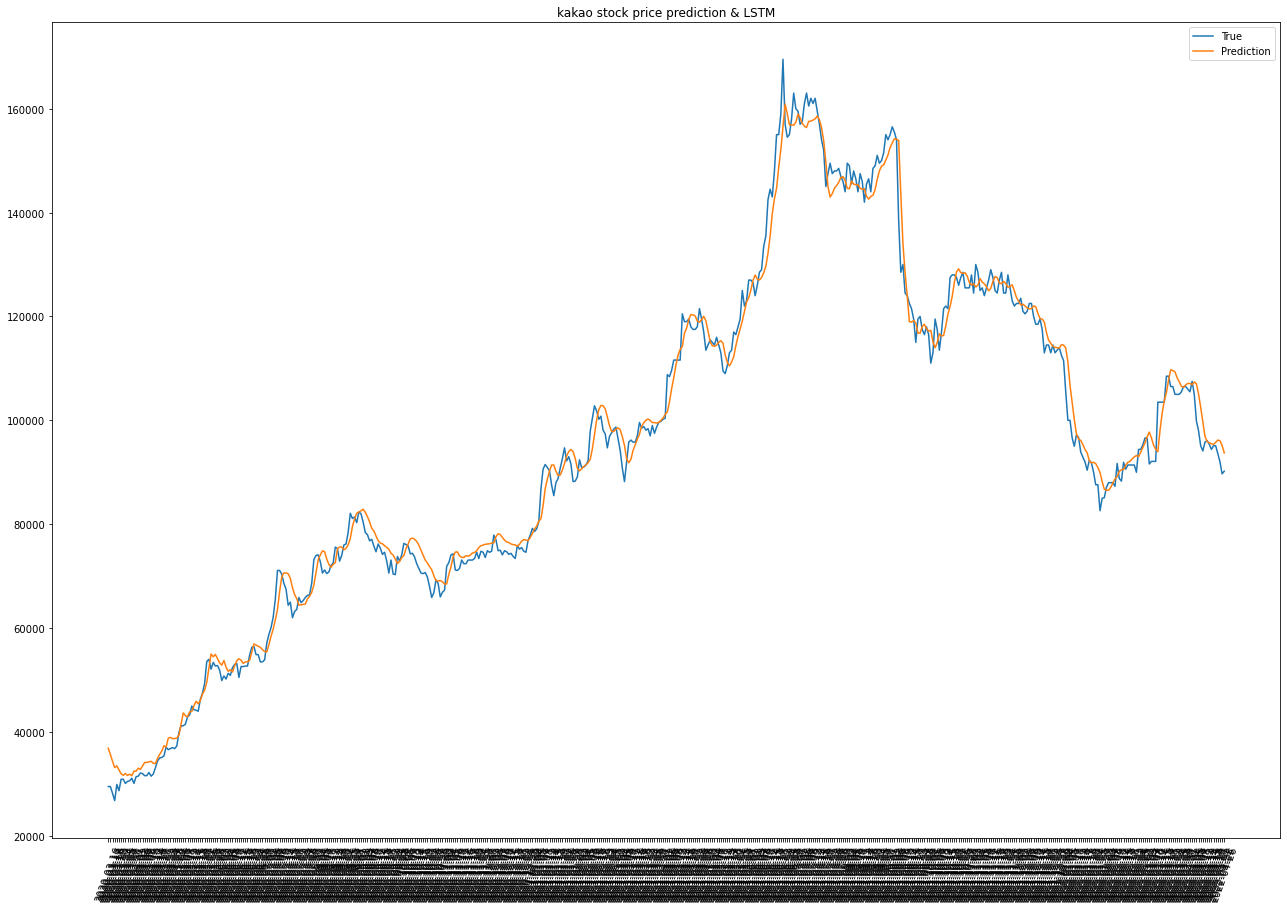

In [57]:
import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

true = plt.plot(unscaled_y[start:end], label='True')
pred = plt.plot(y_predicted[start:end], label='Prediction')

plt.xticks(range(len(unscaled_y[start:end])),data1[50:-1].index, rotation=70)
# plt.xticks(range(len(unscaled_y[start:end]),10),data1.iloc[].index, rotation=70)
# plt.xlim([0,523])
plt.legend(['True', 'Prediction'])
plt.title('kakao stock price prediction & LSTM')
plt.show()

In [58]:
unscaled_y.shape # (523, 1)
y_predicted.shape # (523, 1)
data1[50:].index
range(len(unscaled_y))

range(0, 523)

In [59]:
# 실제주가, 예측주가 데이터프레임 확인
col_name = ['true', 'pred']
true, pred = pd.DataFrame(unscaled_y[start:]), pd.DataFrame(y_predicted[start:])
foo = pd.concat([true, pred], axis = 1)
foo.columns = col_name
foo.index= data1[50:].index
foo

,true,pred
Date,,
2020-03-16,29500.0,36882.226562
2020-03-17,29500.0,35668.250000
2020-03-18,28200.0,34357.921875
2020-03-19,26800.0,33149.636719
2020-03-20,29900.0,33476.472656
...,...,...
2022-04-21,93600.0,96206.531250
2022-04-22,92000.0,96068.953125
2022-04-25,89700.0,95154.875000


In [60]:
# 상관관계 확인
foo.corr()

,true,pred
true,1.00000,0.99562
pred,0.99562,1.00000


In [61]:
foo['true+1'] = foo['true'].shift(periods = 1) # 실제주가를 1일만 앞당긴다면 더 높아진다.
foo[['true+1', 'pred']].corr()

,true+1,pred
true+1,1.000000,0.998238
pred,0.998238,1.000000


In [62]:
# 모델 성능 평가
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

# 실제값, 예측값의 오차 평균값에 기반한 평가
def confirm_result(y_test, y_pred):
    # MAE(평균 절대 오차) : 실제값과 예측값의 차이를 절댓값으로 변환하고 평균해 손실을 계산
    MAE = mean_absolute_error(y_test, y_pred)
    # RMSE(평균 제곱근 오차) : MSE(실제값과 예측값의 차이를 제곱해 평균한 것)에 루트를 씌운 값
    # RMSE값이 적을 수록 더 좋은 성능이라고 평가할 수 있다. 
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    # MSLE : MSE에 LOG를 적용한 지표이다.
    MSLE = mean_squared_log_error(y_test, y_pred)
    # RMSLE : RMSE에 LOG를 적용한 지표이다.
    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    # R2 : 자유도 조정 결정계수(실제값의 분산 대비 예측값의 분산 비율을 지표로 함)
    # 1에 가까울 수록 예측 정확도가 높다
    R2 = r2_score(y_test, y_pred)
    
    pd.options.display.float_format = '{:.5f}'.format
    Result = pd.DataFrame(data=[MAE,RMSE, RMSLE, R2],
                         index = ['MAE','RMSE', 'RMSLE', 'R2'],
                         columns=['Results'])
    return Result

In [ ]:
# y_pred = pd.DataFrame(y_predicted[:, 0])
# y_test = price_test['Adj.Close'][0:len(y_predicted)]
# y_test.reset_index(drop=True, inplace=True)

In [63]:
confirm_result(unscaled_y, y_predicted)

,Results
MAE,2436.70503
RMSE,3228.65983
RMSLE,0.03904
R2,0.99049
